# scikit-image panorama demo

This notebook may be found at https://github.com/scikit-image/scikit-image-demos

Short text descriptions follow most code cells.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from skimage.color import rgb2gray

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')

In [2]:
ic = io.ImageCollection('data/*')

The ``ImageCollection`` class provides an easy way of
loading and representing multiple images.  Images are not
read from disk until accessed.

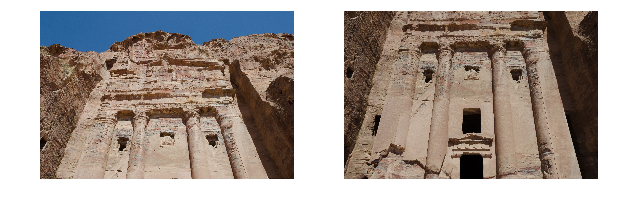

In [3]:
compare(ic[0], ic[1], figsize=(10, 10))

Credit: Photographs taken in Petra, Jordan by François Malan<br/>
License: CC-BY

In [4]:
image0 = rgb2gray(ic[0][:, 500:500+1987, :])
image1 = rgb2gray(ic[1][:, 500:500+1987, :])

image0 = transform.rescale(image0, 0.25)
image1 = transform.rescale(image1, 0.25)

/Users/marc2/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/marc2/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/marc2/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


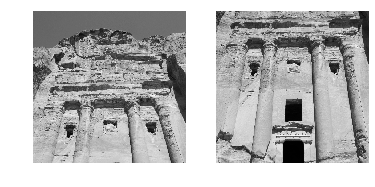

In [5]:
compare(image0, image1)

For this demo, we estimate a projective transformation
that relates the two images.  Since the outer
parts of these photographs do not comform well to such
a model, we select only the central parts.  To
further speed up the demonstration, images are downscaled
to 25% of their original size.

# 1. Feature detection and matching

"Oriented FAST and rotated BRIEF" features are detected in both images:

In [20]:
from skimage.feature import ORB, match_descriptors, plot_matches

orb = ORB(n_keypoints=40, fast_threshold=0.05)

orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

(0.0, 994.0, 497.0, 0.0)

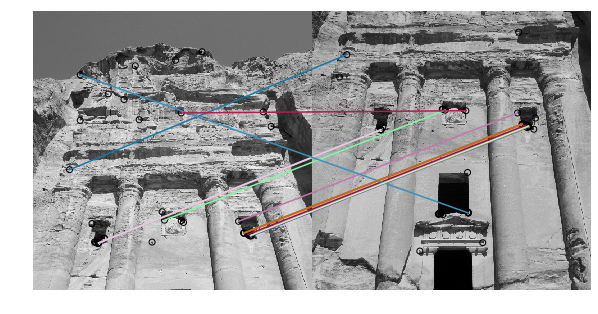

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12)
ax.axis('off')

Each feature yields a binary descriptor; those are used to find
the putative matches shown.  Many false matches are observed.

# 2. Transform estimation

To filter matches, we apply RANdom SAMple Consensus (RANSAC),
a common method of rejecting outliers.  This iterative process
estimates transformation models based on
randomly chosen subsets of matches, finally selecting the
model which corresponds best with the majority of matches.

In [8]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.feature import plot_matches

# Select keypoints from the source (image to be registered)
# and target (reference image)
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust, inliers = ransac((src, dst), ProjectiveTransform,
                               min_samples=4, residual_threshold=1, max_trials=300)

(0.0, 994.0, 497.0, 0.0)

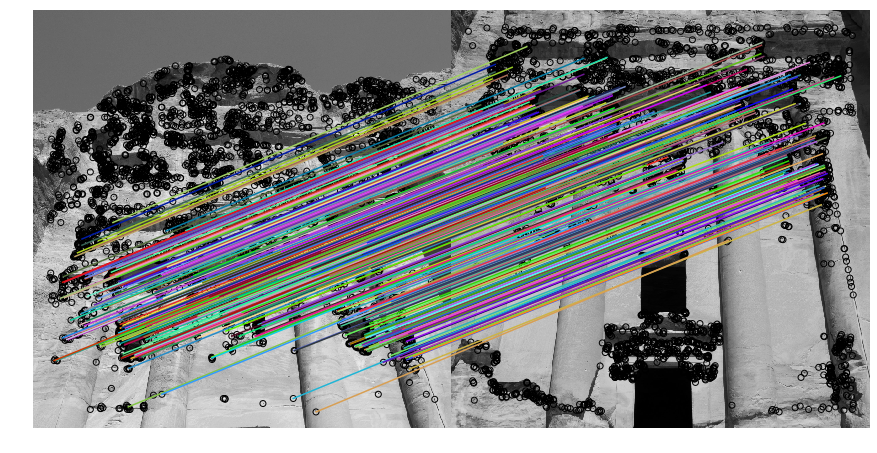

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12[inliers])
ax.axis('off')

Note how most of the false matches have now been rejected.

# 3. Warping

Next, we want to produce the panorama itself.  The first
step is to find the shape of the output image, by taking
considering the extents of all warped images.

In [10]:
from skimage.transform import SimilarityTransform

r, c = image1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners = model_robust(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

Warp the images according to the estimated transformation model.
Values outside the input images are set to -1 to distinguish the
"background".

A shift is added to make sure that both images are visible in their
entirety.  Note that ``warp`` takes the inverse mapping
as an input.

In [11]:
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.transform import warp

offset = SimilarityTransform(translation=-corner_min)

image0_ = warp(image0, offset.inverse,
               output_shape=output_shape, cval=-1)

image1_ = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape, cval=-1)

An alpha channel is now added to the warped images
before they are merged together:

In [12]:
def add_alpha(image, background=-1):
    """Add an alpha layer to the image.
    
    The alpha layer is set to 1 for foreground and 0 for background.
    """
    return np.dstack((gray2rgb(image), (image != background)))

image0_alpha = add_alpha(image0_)
image1_alpha = add_alpha(image1_)

merged = (image0_alpha + image1_alpha)
alpha = merged[..., 3]

# The summed alpha layers give us an indication of how many
# images were combined to make up each pixel.  Divide by the
# number of images to get an average.
merged /= np.maximum(alpha, 1)[..., np.newaxis]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


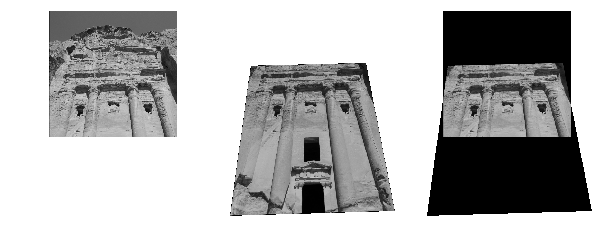

In [13]:
compare(image0_alpha, image1_alpha, merged, figsize=(10, 10))

Note that, while the columns are well aligned, the color
intensity is not well matched between images.

# 4. Blending

To blend images smoothly we make use of the open source package
[Enblend](http://enblend.sf.net), which in turn employs multi-resolution splines and 
Laplacian pyramids [1, 2].

[1]	P. Burt and E. Adelson. ["A Multiresolution Spline With Application to Image Mosaics"](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.56.690). ACM Transactions on Graphics, Vol. 2, No. 4, October 1983. Pg. 217-236.
[2]	P. Burt and E. Adelson. ["The Laplacian Pyramid as a Compact Image Code"](http://dx.doi.org/10.1109/TCOM.1983.1095851). IEEE Transactions on Communications, April 1983.

In [14]:
plt.imsave('/tmp/frame0.tif', image0_alpha)
plt.imsave('/tmp/frame1.tif', image1_alpha)

In [15]:
%%bash

enblend /tmp/frame*.tif -o /tmp/pano.tif

bash: line 2: enblend: command not found


CalledProcessError: Command 'b'\nenblend /tmp/frame*.tif -o /tmp/pano.tif\n'' returned non-zero exit status 127.

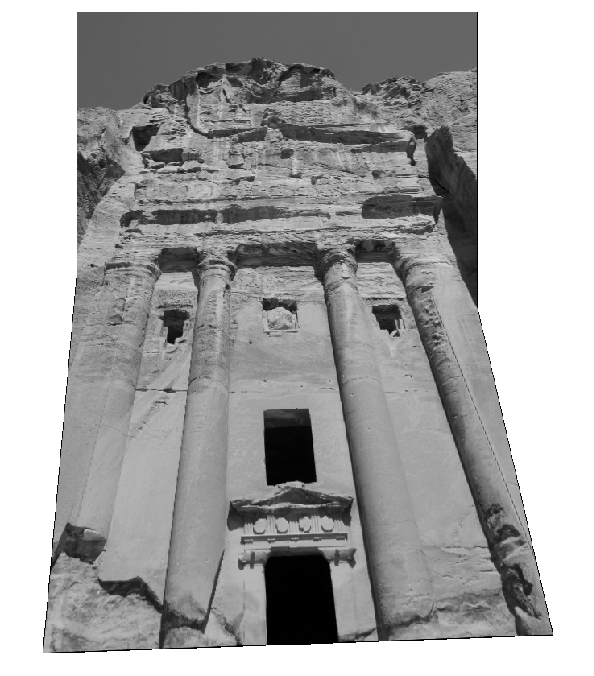

In [16]:
pano = io.imread('/tmp/pano.tif')
compare(pano, figsize=(10, 15))